<a href="https://colab.research.google.com/github/shipra-saxena/miniature-potato/blob/master/assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 3: Image Synthesis

This notebook contains examples, plus the exercises for the second assignment, which should be submitted as instructed in the assignments [page](https://daniel-yukimura.github.io/assingments-image-processing-lab/).

In this assignment we'll practice how to train GANs for image synthesis.


We are also using [Colaboratory](https://colab.research.google.com) for this assignment, where you can use a GPU for training your neural network (go to Edit -> Notebook Settings).


### Example: MNIST
The following example traing a convolutional GAN on the MNIST dataset

In [0]:
!pip3 install -q torch torchvision

tcmalloc: large alloc 1073750016 bytes == 0x586e6000 @  0x7f4a29e2c2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


In [0]:
import torch
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

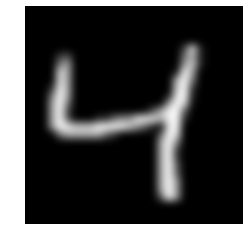

tensor(4)
torch.Size([1, 28, 28])


In [0]:
#Loading dataset
mnist_dataset = datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=True)

def show(img,renorm=False,nrow=8,interpolation='bicubic'):
  if renorm:
    img = img/2 + 0.5
  img_grid = torchvision.utils.make_grid(img,nrow=nrow).numpy()
  plt.figure()
  plt.imshow(np.transpose(img_grid, (1,2,0)), interpolation=interpolation)
  plt.axis('off')
  plt.show()
  
image, label = mnist_dataset.__getitem__(2)
show(image)
print(label)
print(image.shape)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Generator_MNIST(nn.Module):
  
  def __init__(self, z_size=100, out_size=1, ngf=64):
    super(Generator_MNIST, self).__init__()
    self.z_size = z_size
    self.ngf = ngf
    self.out_size = out_size
    
    self.layer1 = nn.Sequential(## 1x1 to 4x4
        nn.ConvTranspose2d(self.z_size, self.ngf * 4, 4, 1, 0, bias=False),
        nn.BatchNorm2d(self.ngf * 4),
        nn.ReLU(inplace=True)
    )
    
    self.layer2 = nn.Sequential(## 4x4 to 7x7
        nn.ConvTranspose2d(self.ngf * 4, self.ngf * 2, 3, 2, 1, bias=False),
        nn.BatchNorm2d(self.ngf * 2),
        nn.ReLU(inplace=True)
    )
    
    self.layer3 = nn.Sequential(## 7x7 to 14x14
        nn.ConvTranspose2d(self.ngf * 2, self.ngf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(self.ngf),
        nn.ReLU(inplace=True)
    )
    
    self.layer4 = nn.Sequential(## 14x14 to 28x28
        nn.ConvTranspose2d(self.ngf, self.out_size, 4, 2, 1, bias=False),
        nn.Tanh()
    )
    
  def initialize(self):
    for m in self.modules():
      if isinstance(m, nn.ConvTranspose2d):
        m.weight.data.normal_(0.0, 0.02)
        if m.bias is not None:
          m.bias.data.zero_()
    
  def forward(self, z):
    out = self.layer1(z)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    return out

In [0]:
class Discriminator_MNIST(nn.Module):
  
  def __init__(self, in_size=1, ndf=64):
    super(Discriminator_MNIST, self).__init__()
    self.in_size = in_size
    self.ndf = ndf
    
    self.layer1 = nn.Sequential(## 28x28 to 14x14
      nn.Conv2d(self.in_size, self.ndf, 4, 2, 1, bias=False),
      nn.LeakyReLU(0.2, inplace=True)
    )
    
    self.layer2 = nn.Sequential(## 14x14 to 7x7
      nn.Conv2d(self.ndf, self.ndf * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(self.ndf * 2),
      nn.LeakyReLU(0.2, inplace=True)
    )
    
    self.layer3 = nn.Sequential(## 7x7 to 4x4
      nn.Conv2d(self.ndf * 2, self.ndf * 4, 3, 2, 1, bias=False),
      nn.BatchNorm2d(self.ndf * 4),
      nn.LeakyReLU(0.2, inplace=True)
    )
    
    self.layer4 = nn.Sequential(## 4x4 to 1
      nn.Conv2d(self.ndf * 4, 1, 4, 1, 0, bias=False),
      nn.Sigmoid()
    )
    
  def initialize(self):
    for m in self.modules():
      if isinstance(m, nn.ConvTranspose2d):
        m.weight.data.normal_(0.0, 0.02)
        if m.bias is not None:
          m.bias.data.zero_()
    
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    return out

In [0]:
from torch.utils.data import DataLoader

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def to_cuda(x):
    return x.to(DEVICE)

batch_size = 64
data_loader = DataLoader(dataset=mnist_dataset, batch_size=batch_size, shuffle=True)

In [0]:
epochs = 100
lr = 0.0002
z_dim = 100

D = to_cuda(Discriminator_MNIST())
G = to_cuda(Generator_MNIST())

criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=lr)
G_opt = torch.optim.Adam(G.parameters(), lr=lr)

In [0]:
fixed_noise = to_cuda(torch.randn(batch_size, z_dim).view(-1, 100, 1, 1))
n_critic = 1

D.initialize()
G.initialize()

step = 0
for epoch in range(epochs):
  for idx, (img_batch, _) in enumerate(data_loader):
    step += 1
    mbatch_size = img_batch.size()[0]
    D_labels = to_cuda(torch.ones(mbatch_size)) # Discriminator Label to real
    D_fakes = to_cuda(torch.zeros(mbatch_size)) # Discriminator Label to fake
    # Training Discriminator
    x = to_cuda(img_batch)
    x_disc = D(x)
    D_x_loss = criterion(x_disc, D_labels)

    z = to_cuda(torch.randn(mbatch_size, z_dim).view(-1, z_dim, 1, 1))
    z_disc = D(G(z))
    D_z_loss = criterion(z_disc, D_fakes)
    D_loss = D_x_loss + D_z_loss

    D.zero_grad()
    D_loss.backward()
    D_opt.step()
    
    if step % n_critic == 0:
      # Training Generator
      z = to_cuda(torch.randn(mbatch_size, z_dim).view(-1, z_dim, 1, 1))
      z_disc = D(G(z))
      G_loss = criterion(z_disc, D_labels)

      D.zero_grad()
      G.zero_grad()
      G_loss.backward()
      G_opt.step()
        
    if step % 100 == 0:
      print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, epochs, step, D_loss.data[0], G_loss.data[0]))
    if step % 1000 == 0:
      G.eval()
      fake = G(fixed_noise)
      imgs = fake.detach().cpu()
      show(imgs[0:16],nrow=8)
      G.train()

NameError: ignored

## Exercise 1: Fashion-MNIST
The [Zalando's](https://github.com/zalandoresearch/fashion-mnist) **Fashion-MNIST** dataset is a drop-in replacement for the MNIST dataset, it has the same framework of grayscale $28\times 28$ images, in a split of 60k training, 10k test, as in the original MNIST dataset. Take a look at the dataset:
![](https://kaggle2.blob.core.windows.net/datasets-images/2243/3791/9384af51de8baa77f6320901f53bd26b/data-original.png)


### Labels:
We have fashion products divided into 10 classes:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

### Tasks:

*  Train a convolutional GAN on the Fashion-MNIST dataset, available in **torchvision.datasets**. You can use the same model from the previows example, or a different one.
*  Compare the result with the previows application. Check if is possible to get a substantial improvement on the quality by rising the capacity of the models, for example by rising the parameters **ngf** and **ndf**.

<hr>

## Exercise 2: Face Synthesis (CelebA)
The **CelebFaces Attributes Dataset (CelebA)** is a large-scale dataset containing $\geq 200k$ celebrety face images, each with $40$ attribute annotations. It's a famous dataset, which allows tackling into complex questions of image synthesis. In this assignmente we focus on trying to randomly generate images similar to the dataset, i.e. to generate new unprecedent faces.

The images have dimensions $178\times 218$ which will be somehow large for us, will work with crop and resized versions of $64\times 64$. The following code will help you downloading and formatting the dataset.


In [0]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

--2018-10-23 17:00:02--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.20.45
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.20.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  66.0MB/s    in 33s     

2018-10-23 17:00:35 (42.0 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [0]:
import zipfile

with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [0]:
import os
root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


In [0]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
import PIL.Image as Image
""" data """
crop_size = 108
re_size = 64
offset_height = (218 - crop_size) // 2
offset_width = (178 - crop_size) // 2
crop = lambda x: x[:, offset_height:offset_height + crop_size, offset_width:offset_width + crop_size]

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(crop),
     transforms.ToPILImage(),
     transforms.Scale(size=(re_size, re_size), interpolation=Image.BICUBIC),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)])

batch_size = 64
celeba_data = datasets.ImageFolder('./data_faces', transform=transform)
data_loader = DataLoader(celeba_data,batch_size=batch_size,shuffle=True)

    100% |████████████████████████████████| 5.6MB 5.9MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL
    100% |████████████████████████████████| 7.3MB 5.2MB/s 


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


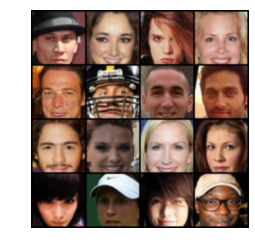

In [0]:
batch, _ = next(iter(data_loader))
show(batch[0:16], renorm = True, nrow=4)

### Tasks: 

*  Create a convolutional GAN model that can be trained in $64x64x3$ images. This should be easy when taking the given MNIST model as base.
*  Train this GAN model in the CelebA dataset. Check again for improvement on the network capacity.

<hr>

## (Extra) Exercise 3: Conditional GANs

* Modify the MNIST GAN model to make conditional synthesis on the available labels. The idea of encoding the classes was discussed in class.
* Train the conditional model on the MNIST and the Fashion-MNIST datasets.
* Maintain a set of fixed noises, and check how the network is doing on those during training (i.e. plot at least the 10 digits after some number of steps).